In [52]:
import tensorflow as tf
import os
import numpy as np
import pandas as np
from matplotlib import pyplot as plt
import tensorflow_datasets as tfds
from tensorflow.keras import mixed_precision
from tensorflow.keras import layers

import datetime

Constants

In [4]:
print(tf.__version__)

2.9.2


GPU Check

In [1]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-525af518-10e1-cbd4-6f85-5996aa17c31f)


Helper functions

In [6]:
def create_tensorboard_callback(dir_name, experiment_name):
  """
  Creates a TensorBoard callback instand to store log files.
  Stores log files with the filepath:
    "dir_name/experiment_name/current_datetime/"
  Args:
    dir_name: target directory to store TensorBoard log files
    experiment_name: name of experiment directory (e.g. efficientnet_model_1)
  """
  log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(
      log_dir=log_dir
  )
  print(f"Saving TensorBoard log files to: {log_dir}")
  return tensorboard_callback

In [7]:
def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics.
  Args:
    history: TensorFlow model History object (see: https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/History)
  """ 
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();

In [8]:
def compare_historys(original_history, new_history, initial_epochs=5):
    """
    Compares two TensorFlow model History objects.
    
    Args:
      original_history: History object from original model (before new_history)
      new_history: History object from continued model training (after original_history)
      initial_epochs: Number of epochs in original_history (new_history plot starts from here) 
    """
    
    # Get original history measurements
    acc = original_history.history["accuracy"]
    loss = original_history.history["loss"]

    val_acc = original_history.history["val_accuracy"]
    val_loss = original_history.history["val_loss"]

    # Combine original history with new history
    total_acc = acc + new_history.history["accuracy"]
    total_loss = loss + new_history.history["loss"]

    total_val_acc = val_acc + new_history.history["val_accuracy"]
    total_val_loss = val_loss + new_history.history["val_loss"]

    # Make plots
    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(total_acc, label='Training Accuracy')
    plt.plot(total_val_acc, label='Validation Accuracy')
    plt.plot([initial_epochs-1, initial_epochs-1],
              plt.ylim(), label='Start Fine Tuning') # reshift plot around epochs
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(2, 1, 2)
    plt.plot(total_loss, label='Training Loss')
    plt.plot(total_val_loss, label='Validation Loss')
    plt.plot([initial_epochs-1, initial_epochs-1],
              plt.ylim(), label='Start Fine Tuning') # reshift plot around epochs
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.xlabel('epoch')
    plt.show()

# Image data loading

In [10]:
datasets_list = tfds.list_builders()
print("food101" in datasets_list)

True


In [12]:
(train_data, test_data), ds_info = tfds.load(name="food101",
                                             split=['train', 'validation'],
                                             shuffle_files=True,
                                             as_supervised=True,
                                             with_info=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/75750 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/food101/2.0.0.incompleteFTZ6P8/food101-train.tfrecord*...:   0%|          | 0/…

Generating validation examples...:   0%|          | 0/25250 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/food101/2.0.0.incompleteFTZ6P8/food101-validation.tfrecord*...:   0%|         …

Dataset food101 downloaded and prepared to ~/tensorflow_datasets/food101/2.0.0. Subsequent calls will reuse this data.


In [13]:
class_names = ds_info.features['label'].names
print(len(class_names))

101


# Image data exploration

In [14]:
train_one_sample = train_data.take(1)
print(train_one_sample)

<TakeDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>


In [27]:
for image, label in train_one_sample:
  print(f"""
  Image shape: {image.shape}
  Image dtype: {image.dtype}
  Target class from Food101 (tensor form): {label}
  Class name (str form): {class_names[label.numpy()]}
        """)


  Image shape: (512, 512, 3)
  Image dtype: <dtype: 'uint8'>
  Target class from Food101 (tensor form): 77
  Class name (str form): pork_chop
        


(-0.5, 511.5, 511.5, -0.5)

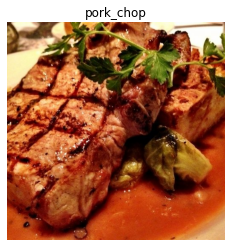

In [28]:
plt.imshow(image)
plt.title(class_names[label.numpy()])
plt.axis(False)

# Image data preprocessing functions

In [29]:
def preprocess_img(image, label, img_shape=224):
    """
    Converts images to dtype float32, and reshapes images to
    (img_shape, img_shape, channels)
    """
    image = tf.image.resize(image, [img_shape, img_shape])
    
    return tf.cast(image, tf.float32), label

In [30]:
preprocessed_img = preprocess_img(image, label)[0]
print(f"Image before preprocessing:\n {image[:2]}...,\nShape: {image.shape},\nDatatype: {image.dtype}\n")
print(f"Image after preprocessing:\n {preprocessed_img[:2]}...,\nShape: {preprocessed_img.shape},\nDatatype: {preprocessed_img.dtype}")

Image before preprocessing:
 [[[ 64  27  11]
  [ 73  36  20]
  [ 83  46  28]
  ...
  [150 105  82]
  [138  93  72]
  [134  89  68]]

 [[ 69  32  16]
  [ 70  33  17]
  [ 72  35  17]
  ...
  [155 110  87]
  [141  96  75]
  [135  90  69]]]...,
Shape: (512, 512, 3),
Datatype: <dtype: 'uint8'>

Image after preprocessing:
 [[[ 69.69388    32.69388    16.693878 ]
  [ 78.44898    41.44898    22.520409 ]
  [ 78.35204    42.566326   16.137754 ]
  ...
  [211.34154   166.91301   141.69875  ]
  [172.38239   127.382385  104.382385 ]
  [138.04063    93.040634   72.040634 ]]

 [[ 63.693874   28.290815   10.499998 ]
  [ 60.137756   25.137754    3.2857132]
  [ 68.54082    33.484695    5.198978 ]
  ...
  [208.20901   164.19371   136.76518  ]
  [184.3518    140.48448   113.76002  ]
  [146.6731    104.673096   79.74452  ]]]...,
Shape: (224, 224, 3),
Datatype: <dtype: 'float32'>


(-0.5, 223.5, 223.5, -0.5)

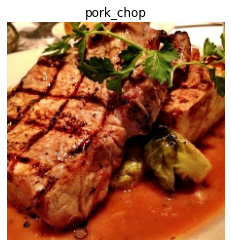

In [31]:
plt.imshow(preprocessed_img / 255.)
plt.title(class_names[label])
plt.axis(False)

## Batching and preparing images into datasets

In [32]:
train_data = train_data.map(map_func=preprocess_img, num_parallel_calls=tf.data.AUTOTUNE)
train_data = train_data.shuffle(buffer_size=1000).batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)

test_data = test_data.map(preprocess_img, num_parallel_calls=tf.data.AUTOTUNE)
test_data = test_data.batch(32).prefetch(tf.data.AUTOTUNE)

## Callbacks

In [34]:
checkpoint_path = "model_checkpoints/cp.ckpt"
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                      monitor="val_accuracy",
                                                      save_best_only=True,
                                                      save_weights_only=True,
                                                      verbose=0)

## Mixed precision training

In [42]:
mixed_precision.set_global_policy(policy="float32")

In [43]:
mixed_precision.global_policy()

<Policy "float32">

# Feature extraction modeling

In [45]:
input_shape = (224, 224, 3)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable=False

inputs = layers.Input(shape=input_shape, name="input_layer")

x = base_model(inputs, training=False)
x = layers.GlobalAveragePooling2D(name="pooling_layer")(x)
x = layers.Dense(len(class_names))(x)

outputs = layers.Activation("softmax", dtype=tf.float32, name="softmax_float32")(x)
model = tf.keras.Model(inputs, outputs)

model.compile(loss="sparse_categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])
print(model.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 pooling_layer (GlobalAverag  (None, 1280)             0         
 ePooling2D)                                                     
                                                                 
 dense (Dense)               (None, 101)               129381    
                                                                 
 softmax_float32 (Activation  (None, 101)              0         
 )                                                               
                                                                 
Total params: 4,178,952
Trainable params: 129,381
Non-trainab

In [46]:
for layer in model.layers:
    print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_layer True float32 <Policy "float32">
efficientnetb0 False float32 <Policy "float32">
pooling_layer True float32 <Policy "float32">
dense True float32 <Policy "float32">
softmax_float32 True float32 <Policy "float32">


In [53]:
tf.get_logger().setLevel('ERROR')

history_food_classes_feature_extract = model.fit(train_data,
                                                 epochs=3,
                                                 steps_per_epoch=len(train_data),
                                                 validation_data=test_data,
                                                 validation_steps=int(0.15 * len(test_data)),
                                                 callbacks=[create_tensorboard_callback("training_logs", "efficientnetb0_classes_all_data_feature_extract"),
                                                            model_checkpoint])

Saving TensorBoard log files to: training_logs/efficientnetb0_classes_all_data_feature_extract/20221030-074409
Epoch 1/3
2368/2368 [==============================] - 219s 86ms/step - loss: 1.7165 - accuracy: 0.5815 - val_loss: 1.1214 - val_accuracy: 0.7013
Epoch 2/3
2368/2368 [==============================] - 189s 79ms/step - loss: 1.1997 - accuracy: 0.6895 - val_loss: 1.0392 - val_accuracy: 0.7156
Epoch 3/3
2368/2368 [==============================] - 218s 91ms/step - loss: 1.0522 - accuracy: 0.7253 - val_loss: 0.9979 - val_accuracy: 0.7193


In [54]:
results_feature_extract_model = model.evaluate(test_data)
print(results_feature_extract_model)

790/790 [==============================] - 63s 80ms/step - loss: 1.0000 - accuracy: 0.7273
[0.9999604821205139, 0.7272871136665344]


## Loading and evaluating model

In [55]:
model_clone = tf.keras.models.clone_model(model)
print(model_clone.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 pooling_layer (GlobalAverag  (None, 1280)             0         
 ePooling2D)                                                     
                                                                 
 dense (Dense)               (None, 101)               129381    
                                                                 
 softmax_float32 (Activation  (None, 101)              0         
 )                                                               
                                                                 
Total params: 4,178,952
Trainable params: 129,381
Non-trainab

In [56]:
model_clone.load_weights(checkpoint_path)

In [57]:
model_clone.compile(loss="sparse_categorical_crossentropy",
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=["accuracy"])

results_model_clone = model_clone.evaluate(test_data)

790/790 [==============================] - 59s 71ms/step - loss: 1.3791 - accuracy: 0.6310


## Saving model

In [58]:
save_dir = "efficientnetb0_feature_extract_model_mixed_precision"
model.save(save_dir)

In [59]:
loaded_model = tf.keras.models.load_model(save_dir)

# Fine tuning modeling

In [60]:
for layer in loaded_model.layers:
    layer.trainable = True
    print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_layer True float32 <Policy "float32">
efficientnetb0 True float32 <Policy "float32">
pooling_layer True float32 <Policy "float32">
dense True float32 <Policy "float32">
softmax_float32 True float32 <Policy "float32">


In [62]:
for layer in loaded_model.layers[1].layers[:20]:
    print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_3 True float32 <Policy "float32">
rescaling_2 True float32 <Policy "float32">
normalization_2 True float32 <Policy "float32">
tf.math.truediv_2 True float32 <Policy "float32">
stem_conv_pad True float32 <Policy "float32">
stem_conv True float32 <Policy "float32">
stem_bn True float32 <Policy "float32">
stem_activation True float32 <Policy "float32">
block1a_dwconv True float32 <Policy "float32">
block1a_bn True float32 <Policy "float32">
block1a_activation True float32 <Policy "float32">
block1a_se_squeeze True float32 <Policy "float32">
block1a_se_reshape True float32 <Policy "float32">
block1a_se_reduce True float32 <Policy "float32">
block1a_se_expand True float32 <Policy "float32">
block1a_se_excite True float32 <Policy "float32">
block1a_project_conv True float32 <Policy "float32">
block1a_project_bn True float32 <Policy "float32">
block2a_expand_conv True float32 <Policy "float32">
block2a_expand_bn True float32 <Policy "float32">


## Fine tuning callbacks

In [64]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                                                  patience=3)

checkpoint_path = "fine_tune_checkpoints/"
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                      save_best_only=True,
                                                      monitor="val_loss")

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",
                                                 factor=0.2,
                                                 patience=2,
                                                 verbose=1,
                                                 min_lr=1e-7)

## Fine tuning

In [65]:
loaded_model.compile(loss="sparse_categorical_crossentropy", optimizer=tf.keras.optimizers.Adam(0.0001), metrics=['accuracy'])

In [ ]:
history_food_classes_fine_tune = loaded_model.fit(train_data,
                                                  epochs=100,
                                                  steps_per_epoch=len(train_data),
                                                  validation_data=test_data,
                                                  validation_steps=int(0.15 * len(test_data)),
                                                  callbacks=[create_tensorboard_callback("training_logs", "efficientnetb0_classes_all_data_fine_tuning"),
                                                             model_checkpoint,
                                                             early_stopping,
                                                             reduce_lr])

Saving TensorBoard log files to: training_logs/efficientnetb0_classes_all_data_fine_tuning/20221030-080620
Epoch 1/100
2368/2368 [==============================] - ETA: 0s - loss: 0.8702 - accuracy: 0.7667

2368/2368 [==============================] - 863s 359ms/step - loss: 0.8702 - accuracy: 0.7667 - val_loss: 0.7517 - val_accuracy: 0.7913 - lr: 1.0000e-04
Epoch 2/100
1136/2368 [=============>................] - ETA: 6:53 - loss: 0.5214 - accuracy: 0.8553

In [ ]:
loaded_model.save("efficientnetb0_classes_fine_tuned")